Time Series Analysis:


In [1]:
import os
import math 
# Essential libaries
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
# preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

c:\Users\blais\Documents\ML\venv2\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [7]:
directory = r"C:\Users\blais\Documents\ML\data\time-series-collection"

In [10]:
mySeries = []
namesofMySeries = []
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        df = pd.read_csv(f"{directory}\{filename}")
        df = df.loc[:,["date","value"]]
        df.set_index("date", inplace=True)
        df.sort_index(inplace=True)
        mySeries.append(df)
        namesofMySeries.append(filename[:-4])


In [11]:
print(len(mySeries))

23


In [13]:
mySeries[0]

,value
date,
1992-02-01,3.9
1992-03-01,10.0
1992-04-01,4.7
1992-05-01,4.1
1992-06-01,-2.9
...,...
2019-05-01,7.8
2019-06-01,-4.9
2019-07-01,1.1


For all 23 time series, lets create a 6 by 4 grid, which will result in 24 slots and then fill it with the plot of our series:

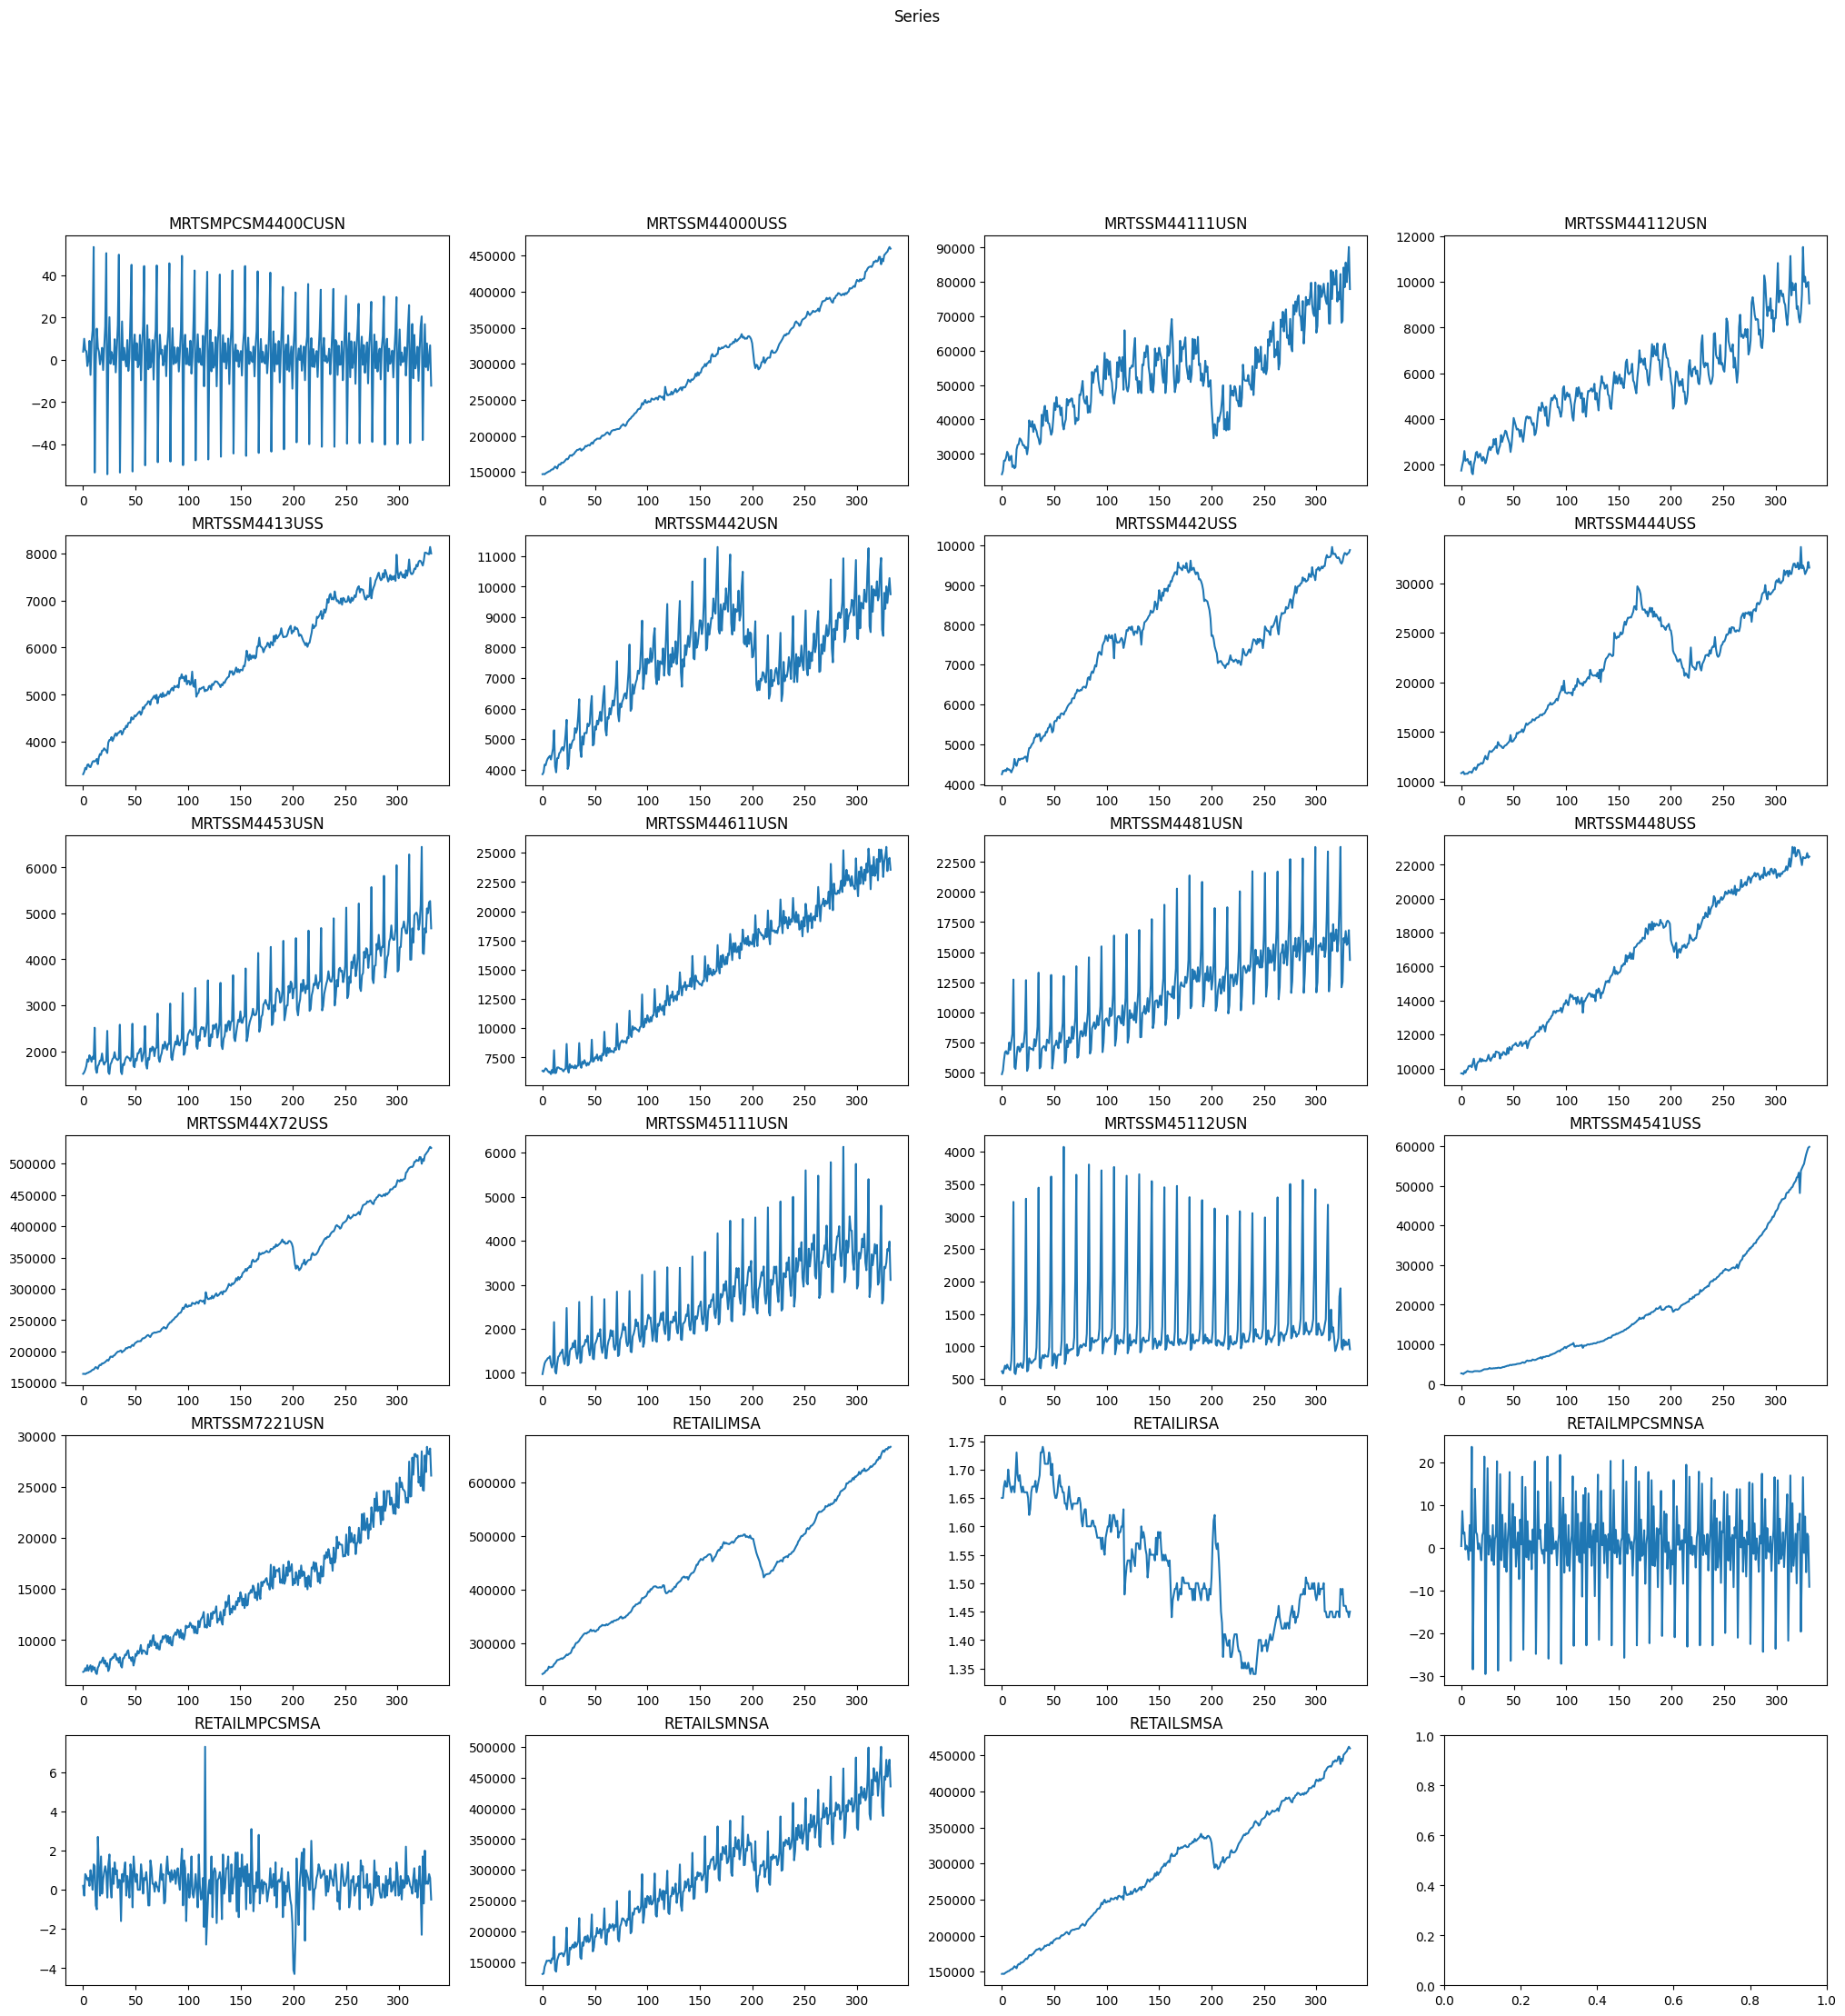

In [14]:
fig, ax = plt.subplots(6,4,figsize=(25,25))
fig.suptitle("Series")
for i in range(6):
    for j in range(4):
        if i*4+j+1 > len(mySeries):
            continue 
        ax[i,j].plot(mySeries[i*4+j].values)
        ax[i,j].set_title(namesofMySeries[i*4+j])
plt.show()
        

Preprocessing:
- Before we start analysing, let's check if our data is uniform in length

In [15]:
series_lengths = {len(series) for series in mySeries}
print(series_lengths)

{332, 333}


Not all series are uniform in length and we've got 2 unique lengths.
- We should find which series contain missing data and fill them. Because, otherwise, our indices will be shifted and the i.th 

In [17]:
ind = 0
for series in mySeries:
    print("["+str(ind)+"]" + series.index[0] +" "+series.index[len(series)-1])
    ind+=1

[0]1992-02-01 2019-09-01
[1]1992-01-01 2019-09-01
[2]1992-01-01 2019-09-01
[3]1992-01-01 2019-09-01
[4]1992-01-01 2019-09-01
[5]1992-01-01 2019-09-01
[6]1992-01-01 2019-09-01
[7]1992-01-01 2019-09-01
[8]1992-01-01 2019-09-01
[9]1992-01-01 2019-09-01
[10]1992-01-01 2019-09-01
[11]1992-01-01 2019-09-01
[12]1992-01-01 2019-09-01
[13]1992-01-01 2019-09-01
[14]1992-01-01 2019-09-01
[15]1992-01-01 2019-09-01
[16]1992-01-01 2019-09-01
[17]1992-01-01 2019-09-01
[18]1992-01-01 2019-09-01
[19]1992-02-01 2019-09-01
[20]1992-02-01 2019-09-01
[21]1992-01-01 2019-09-01
[22]1992-01-01 2019-09-01


As seen above - there's series that don't start at the same date as others. To solve - find the longest series of the series and elongate others to that. 

In [18]:
max_len = max(series_lengths)
longest_series = None 
for series in mySeries:
    if len(series) == max_len:
        longest_series = series

In [20]:
problems_index = []

for i in range(len(mySeries)):
    if len(mySeries[i]) != max_len:
        problems_index.append(i)
        mySeries[i] = mySeries[i].reindex(longest_series.index)

Because we've reindexed and increased the lengths as well 
- previously shorter series are going to end up with lots of null values
- we can write a function to check the number of series with null values at this point

In [21]:
def nan_counter(list_of_series):
    nan_polluted_series_counter = 0
    for series in list_of_series:
        if series.isnull().sum().sum() > 0:
            nan_polluted_series_counter+=1
    print(nan_polluted_series_counter)

In [25]:
nan_counter(mySeries)

3


We have 3 series polluted with nulls. This is actually just one point - because of the extra date we added at the start. We use linear interpolation to fill the gap.

In [26]:
for i in problems_index:
    mySeries[i].interpolate(limit_direction="both", inplace=True)

We now have no series left with null values:

In [27]:
nan_counter(mySeries)

0


Issue dealt with here:
- Important for all time series to have the same lengths - (same starting and end points)
- Also, its important for all the time series to not have null values.

Now that missing values and series lengths are out of the way, the other issue is the scale of the series. Need to have all the data on the same scale.

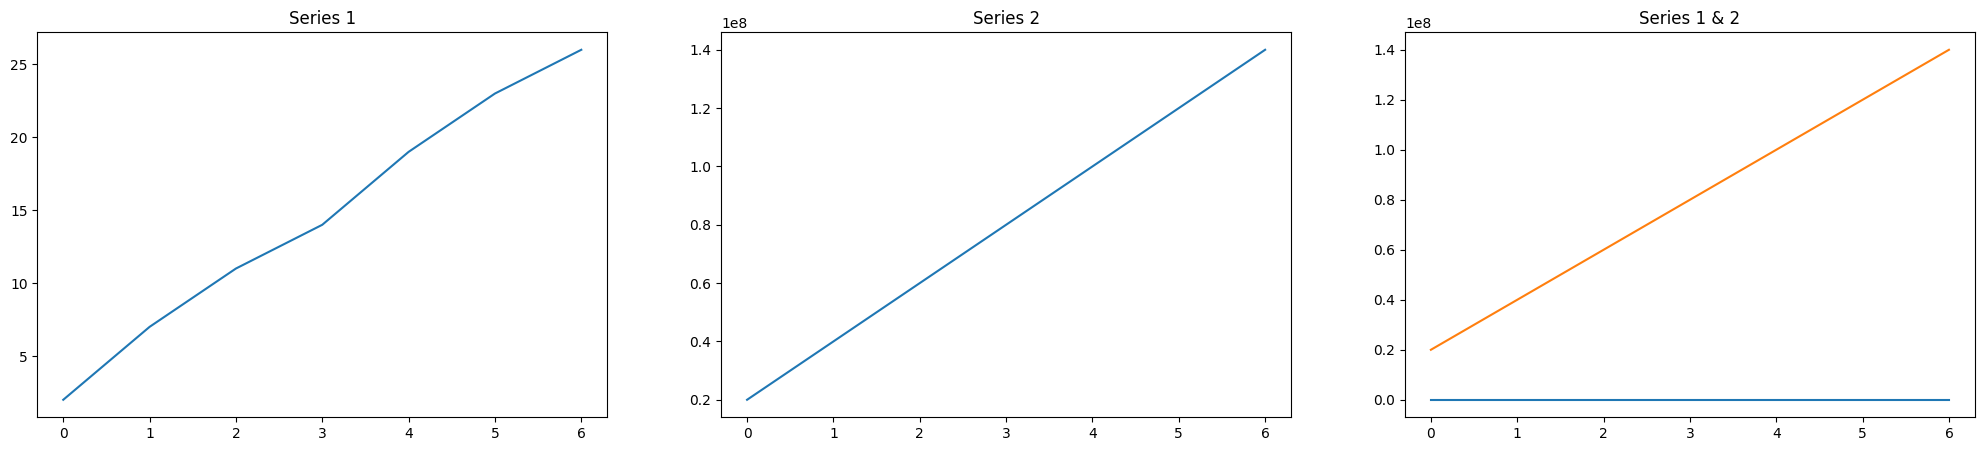

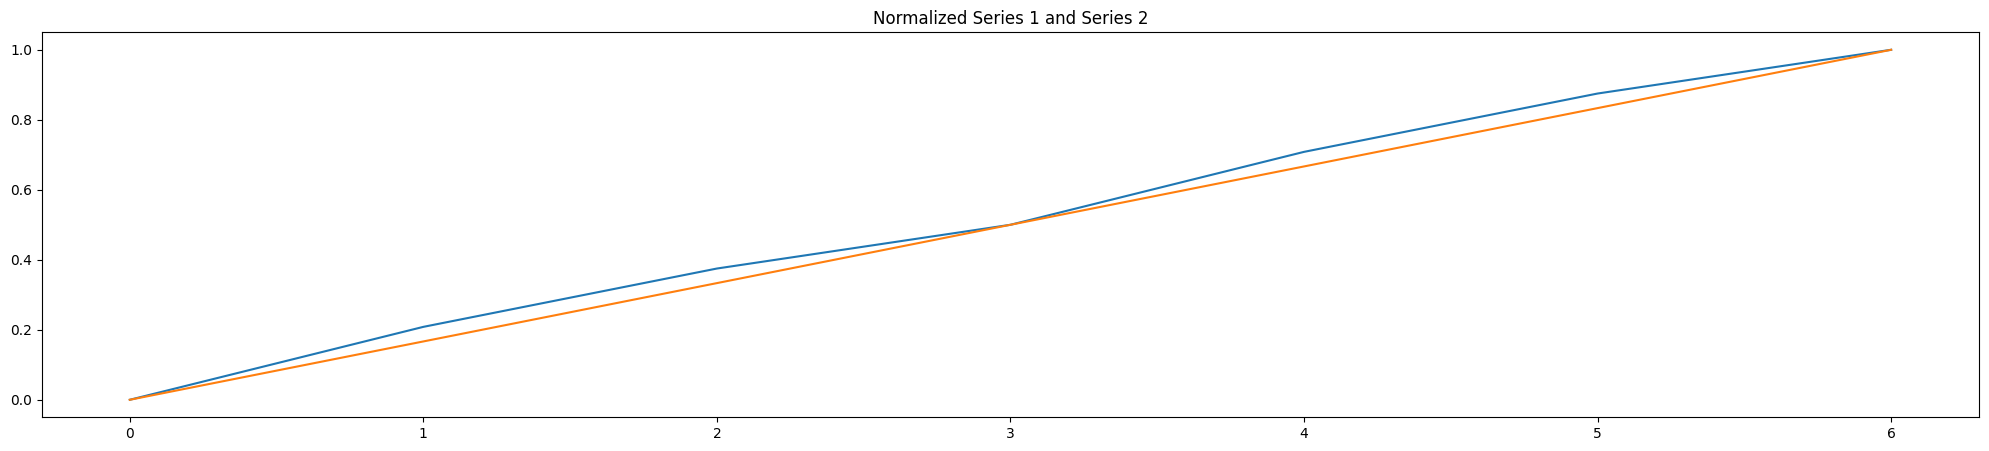

In [28]:
a = [[2],[7],[11],[14],[19],[23],[26]]
b = [[20000000],[40000000],[60000000],[80000000],[100000000],[120000000],[140000000]]

fig, ax = plt.subplots(1,3,figsize=(25,5))
ax[0].plot(a)
ax[0].set_title("Series 1")
ax[1].plot(b)
ax[1].set_title("Series 2")
ax[2].plot(a)
ax[2].plot(b)
ax[2].set_title("Series 1 & 2")
plt.figure(figsize=(25,5))
plt.plot(MinMaxScaler().fit_transform(a))
plt.plot(MinMaxScaler().fit_transform(b))
plt.title("Normalized Series 1 and Series 2")
plt.show()

Above plot illustrates the importance of normalization as series which would have initially been thought to be so different are infact similar. Also, note that we normalized each time series by their own values and not the values of other time series. 

In [29]:
for i in range(len(mySeries)):
    scaler = MinMaxScaler()
    mySeries[i] = MinMaxScaler().fit_transform(mySeries[i])
    mySeries[i] = mySeries[i].reshape(len(mySeries[i]))

The result of the normalizing process seems fine:

In [30]:
print("max: "+str(max(mySeries[0]))+"\tmin: "+str(min(mySeries[0])))
print(mySeries[0][:5])

max: 1.0	min: 0.0
[0.53953488 0.53953488 0.59627907 0.54697674 0.54139535]


**Clustering:**

Self Organising Maps:
- SOM
Self organising maps are a type of neural network that is trained using unsupervised learning to produce a low-dimensional representation of the input space of the training samples, called a map. 

![SOM](https://raw.githubusercontent.com/izzettunc/Kohonen-SOM/master/data/screenshots/landing.png)

Also, self-organising maps differ from other anns as they apply competitive (or cooperative) learning as opposed to error-correction learning (backpropagation with gradient descent), and in the sense that they use a neighborhood function to preserve the topological properties of the input space.

Some SOM notes:
- Parameters:
  - Map size and Topology: - Default: 5*sqrt(n), where n = # of samples
  - Weights Initialization: 
    - random: with small random values
    - sample: with random samples drawn from the input
    - linear: along the linear subspace spanned by the two principle eigenvectors of the dataset
  - Batch and Sequential training

Key arguments of MiniSom:
- x (int): the number of rows in the SOM grid (height of the 2D grid). It determines the grid's vertical resolution. A larger x allows more nodes, enabling finer clustering but increasing computational cost. 
- y (int): determines the grid's horizontal resolution. 
- input_len (int): the dimensionality of the input data (features per data point). Must match the number of columns in your data
- sigma the spead of the neighborhood function, typically a gaussian. significance: controls the radius of inflience of the BMU (Best Matching Unit) during training. A larger sigma affects more neighboring nodes - leading to broader adjustments early in training.
- Learning rate: Initial learning rate for weight updates. Determines how much the weight vectors of the BMU and its neighbors are adjusted toward the input data. A higher value leads to faster learning but may cause instability. It typically decays overtime 

In [53]:
5*math.sqrt(150)

61.23724356957945

In [31]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(mySeries))))

Output Grid Dimensions:

In [33]:
som_x, som_y

(3, 3)

In [34]:
som = MiniSom(som_x, som_y, len(mySeries[0]), sigma=0.3, learning_rate=0.1)

In [35]:
som.random_weights_init(mySeries)

In [41]:
som.train(mySeries,50000)

Results:

Because of the ability to produce a map, SOM is deemed as a method to do dimensionality reduction. But in our case, when each node of the SOM is accepted as medoids of the cluster, we can use it for clustering. To do so, we should remove our time indices and instead focus on the measured value. 

In [47]:
# Little handy function to plot series
def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, ax = plt.subplots(som_x, som_y, figsize=(25,25))
    fig.suptitle("Clusters")
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    ax[cluster].plot(series, c="gray", alpha=0.5)
                ax[cluster].plot(np.average(np.vstack(win_map[cluster]), axis=0), c="red")
            cluster_number = x*som_y+y+1
            ax[cluster].set_title(f"Cluster {cluster_number}")
    plt.show()

In [48]:
win_map = som.win_map(mySeries)

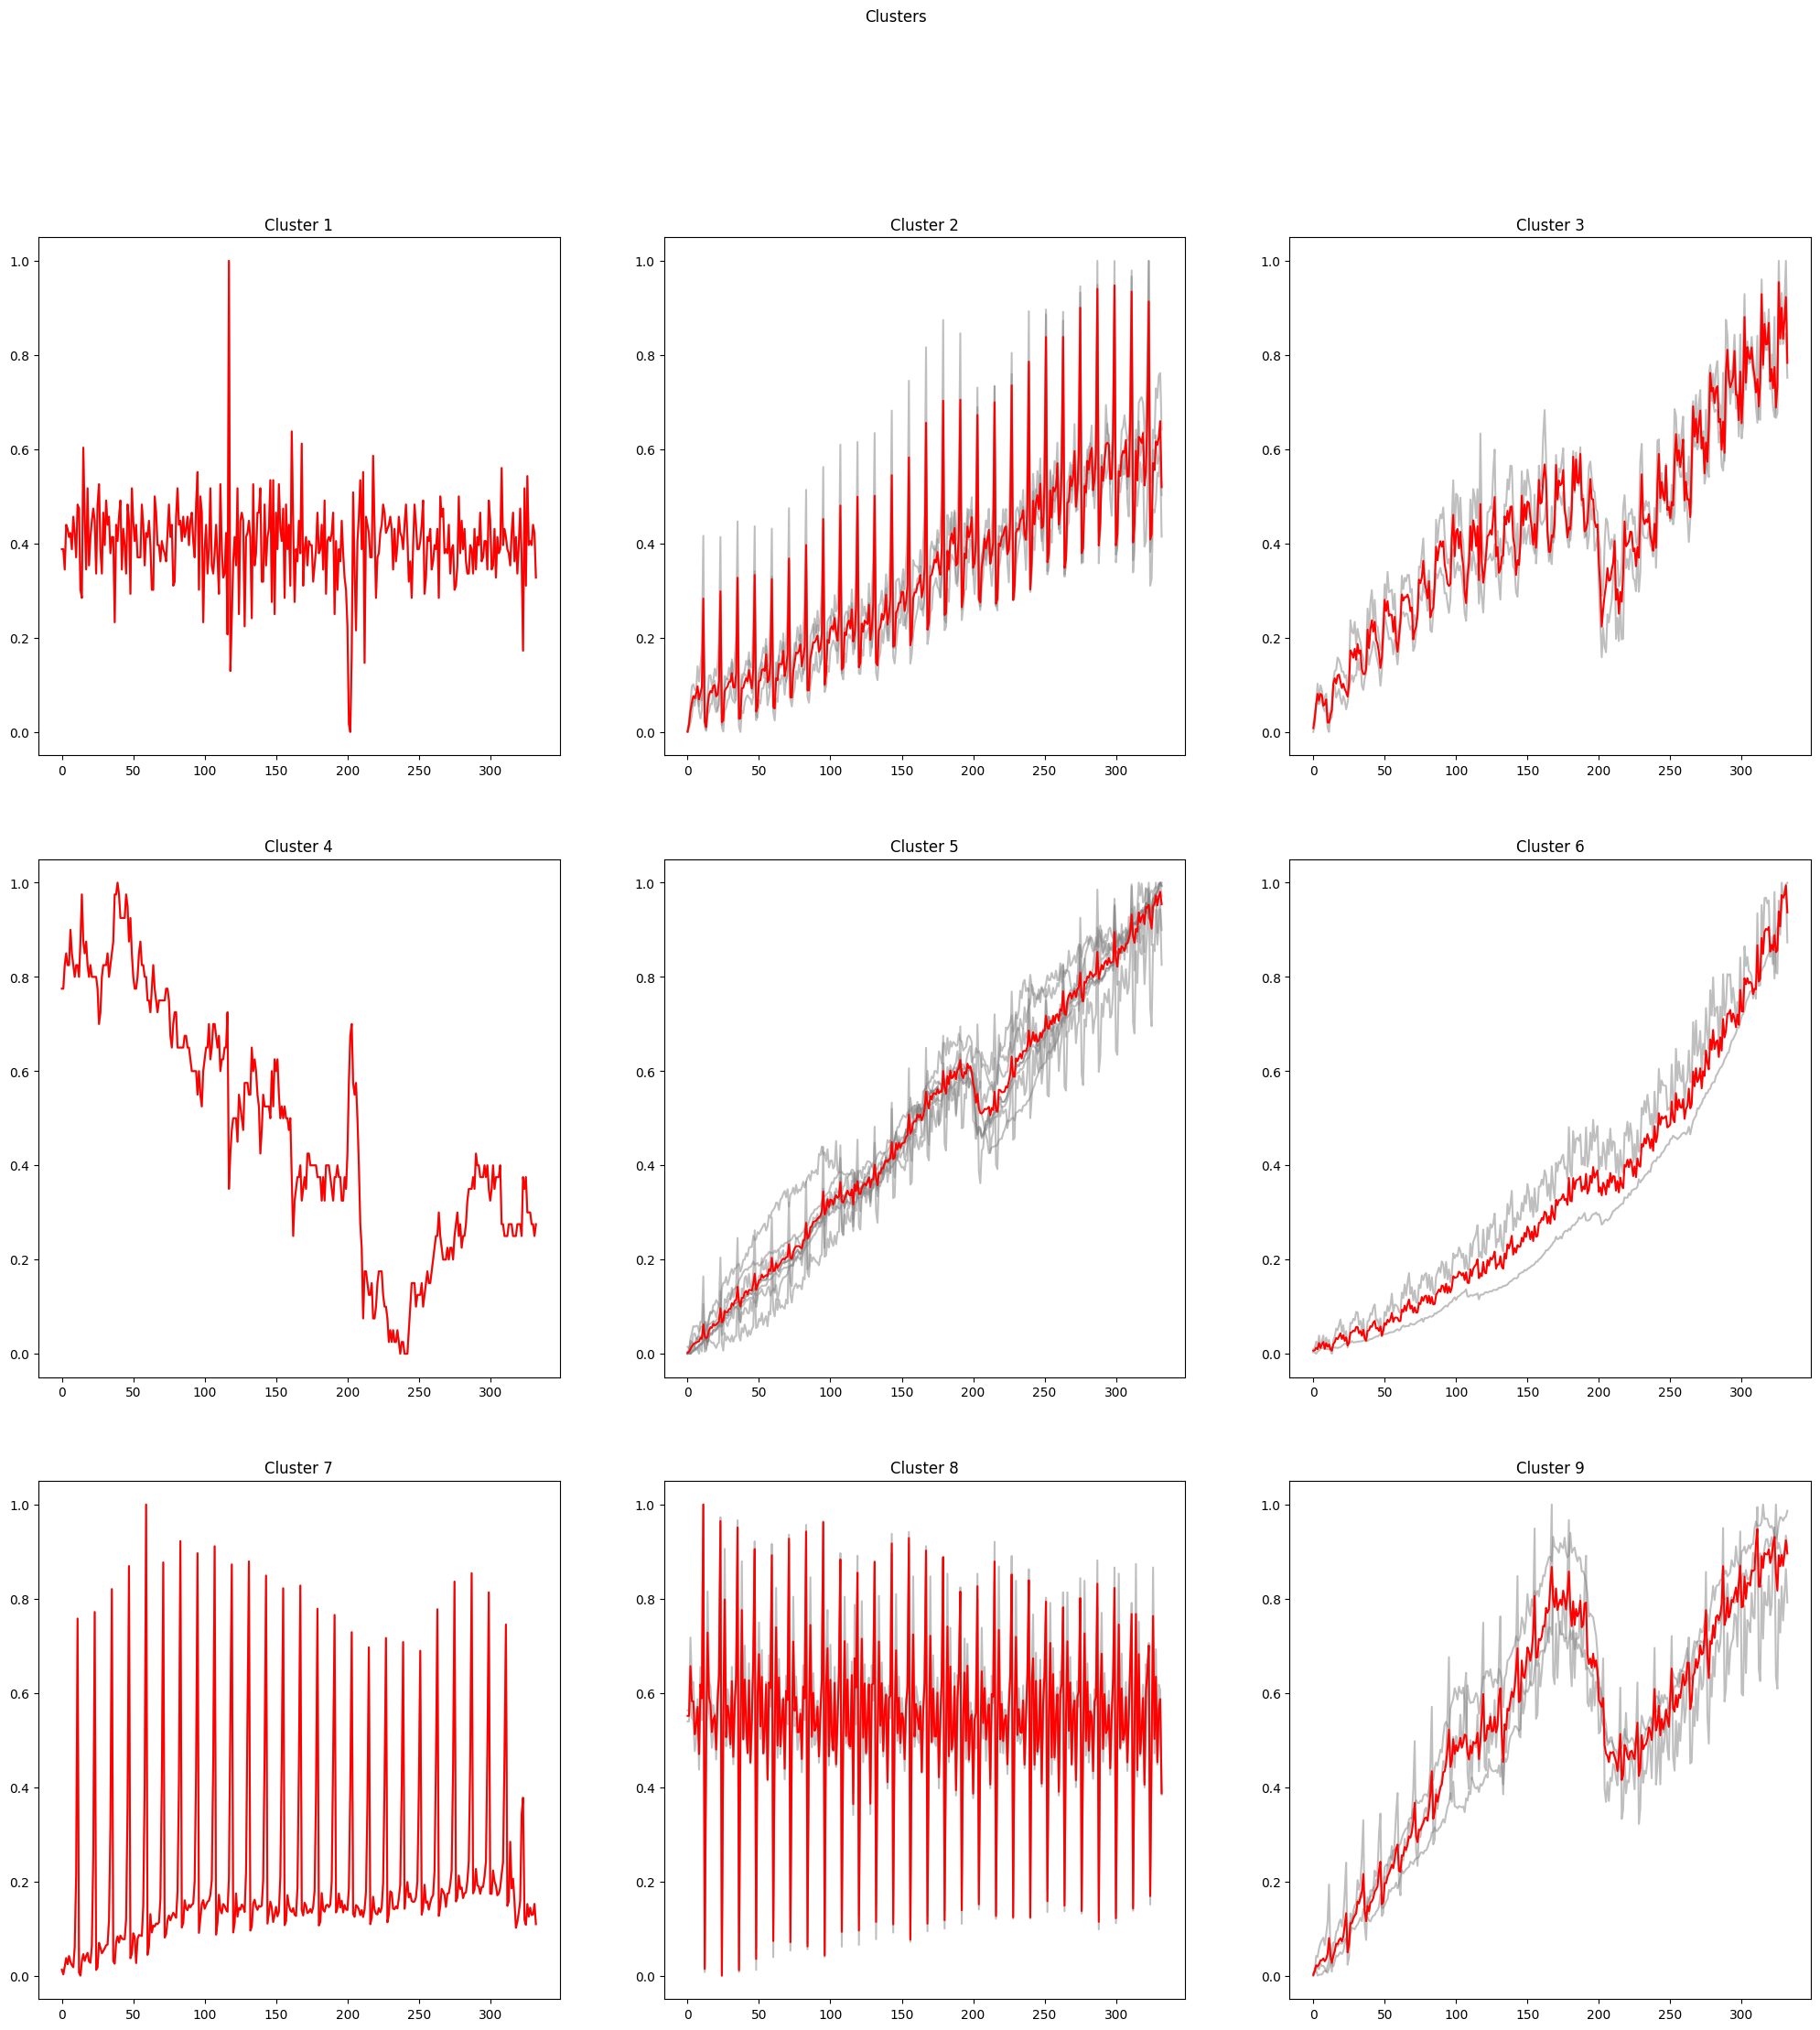

In [50]:
plot_som_series_averaged_center(som_x, som_y, win_map)

Key Hyperparameters:
1. Grid Size (x, y)

    Description: Defines the dimensions of the 2D SOM grid (x rows, y columns), determining the total number of nodes (x * y).
    Tuning Methods:

    Rule of Thumb: Set the number of nodes to approximately $ 5 \sqrt{N} $, where $ N $ is the number of data points, to balance resolution and computational cost. For example, for 150 data points (e.g., Iris dataset), a 10x10 grid (100 nodes) is reasonable.
    Experimentation: Try different grid sizes (e.g., 5x5, 10x10, 20x20) and evaluate using metrics like quantization error (average distance between data points and their BMUs) and topographic error (percentage of data points where the first and second BMUs are not adjacent).
    Dataset Size: Use smaller grids (e.g., 5x5) for small datasets and larger grids (e.g., 20x20) for larger datasets to capture more complex patterns.
    Aspect Ratio: Adjust x and y to reflect the expected data structure (e.g., square grids for balanced data, rectangular for elongated clusters).


    What It Helps Attain:

    Larger Grid (Higher x, y): Increases resolution, allowing finer clustering and capturing more detailed patterns. Useful for complex datasets with many clusters but increases computational cost and may lead to overfitting or empty nodes.
    Smaller Grid (Lower x, y): Reduces computational cost and generalizes better for simpler datasets but may oversimplify, merging distinct clusters.
    Balanced Aspect Ratio: Ensures clusters are not distorted by an overly elongated grid, preserving topological relationships.

2. Learning Rate (learning_rate)
    Description: Controls the step size of weight updates during training. It typically starts at the specified value (e.g., 0.5) and decays over iterations.
    Tuning Methods:
    Range: Test values between 0.1 and 1.0 (e.g., 0.1, 0.3, 0.5, 0.7). Higher values lead to faster convergence, while lower values allow finer adjustments.
    Grid Search: Combine with other parameters in a grid search, evaluating quantization error to find an optimal value.
    Decay Adjustment: If using a custom decay_function, adjust the decay rate to slow down or speed up the reduction of the learning rate.
    Monitor Convergence: Use som.quantization_error(data) after training to check if the learning rate allows sufficient convergence. If the error is high, try a lower learning rate with more iterations.
    What It Helps Attain:
    Higher Learning Rate: Speeds up training, helping the SOM quickly capture broad patterns. Best for initial exploration or datasets with clear clusters but may lead to unstable or suboptimal maps.
    Lower Learning Rate: Enables fine-tuning, improving precision in clustering and reducing quantization error. Ideal for complex datasets but requires more iterations.
    Balanced Decay: Ensures the SOM transitions smoothly from coarse to fine adjustments, improving overall map quality.

3. Neighborhood Radius (sigma)

    Description: Defines the initial spread of the neighborhood function (e.g., Gaussian), which determines how many neighboring nodes are updated around the BMU. It decays over iterations.
    Tuning Methods:

    Initial Value: Start with sigma proportional to the grid size, e.g., $ \sigma = 0.3 \times \max(x, y) $. For a 10x10 grid, try sigma=3.0.
    Experimentation: Test values like 1.0, 2.0, or 5.0, and evaluate topographic error to ensure topology preservation.
    Grid Search: Combine with learning_rate and num_iteration to find a balance that minimizes both quantization and topographic errors.
    Decay Adjustment: Adjust the decay_function to control how quickly sigma shrinks. A slower decay keeps the neighborhood broader for longer, aiding global organization.


    What It Helps Attain:

    Larger sigma: Encourages global organization by influencing more nodes, ensuring similar data points are mapped to nearby regions. Useful for datasets with broad, overlapping clusters but may blur fine details.
    Smaller sigma: Focuses updates on nodes closer to the BMU, capturing local patterns and fine-grained clusters. Best for datasets with distinct, small clusters but may fragment the map if too small.
    Proper Decay: Balances global and local organization, ensuring the map captures both broad structure and detailed clusters.

4. Number of Iterations (num_iteration)

    Description: Specifies the number of training iterations in methods like som.train_random(data, num_iteration).
    Tuning Methods:

    Rule of Thumb: Use 100–1000 iterations for small datasets (e.g., Iris with 150 points) and 1000–10000 for larger datasets.
    Convergence Check: Plot quantization error over iterations (e.g., train for subsets of iterations like 100, 500, 1000) to identify when the error stabilizes.
    Dataset Size: Scale iterations with data size, e.g., $ 10 \times N $ iterations, where $ N $ is the number of data points.
    Early Stopping: If errors (quantization or topographic) stop improving, reduce iterations to save computation.


    What It Helps Attain:

    More Iterations: Improves convergence, reducing quantization error and ensuring the map fully captures data patterns. Essential for large or complex datasets.
    Fewer Iterations: Speeds up training for simple datasets or initial prototyping but may result in an undertrained map with poor clustering.



In [54]:
som.quantization_error(mySeries)

c:\Users\blais\Documents\ML\venv2\lib\site-packages\minisom.py:631: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


0.7784061721090778

Another method to extract the movement/shape of the cluster instead of averaging each series in the cluster, is to use Dynamic Time Warping Barycenter Averaging. DBA is another type of averaging method that used the Dynamic Time Warping method in it and might be very useful to extract the movement/shape of the cluster as seen in below:

![ArithmeticMean](https://raw.githubusercontent.com/fpetitjean/DBA/master/images/arithmetic.png)

![DBA](https://raw.githubusercontent.com/fpetitjean/DBA/master/images/DBA.png)

In [55]:
def plot_som_series_dba_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(dtw_barycenter_averaging(np.vstack(win_map[cluster])),c="red") # I changed this part
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

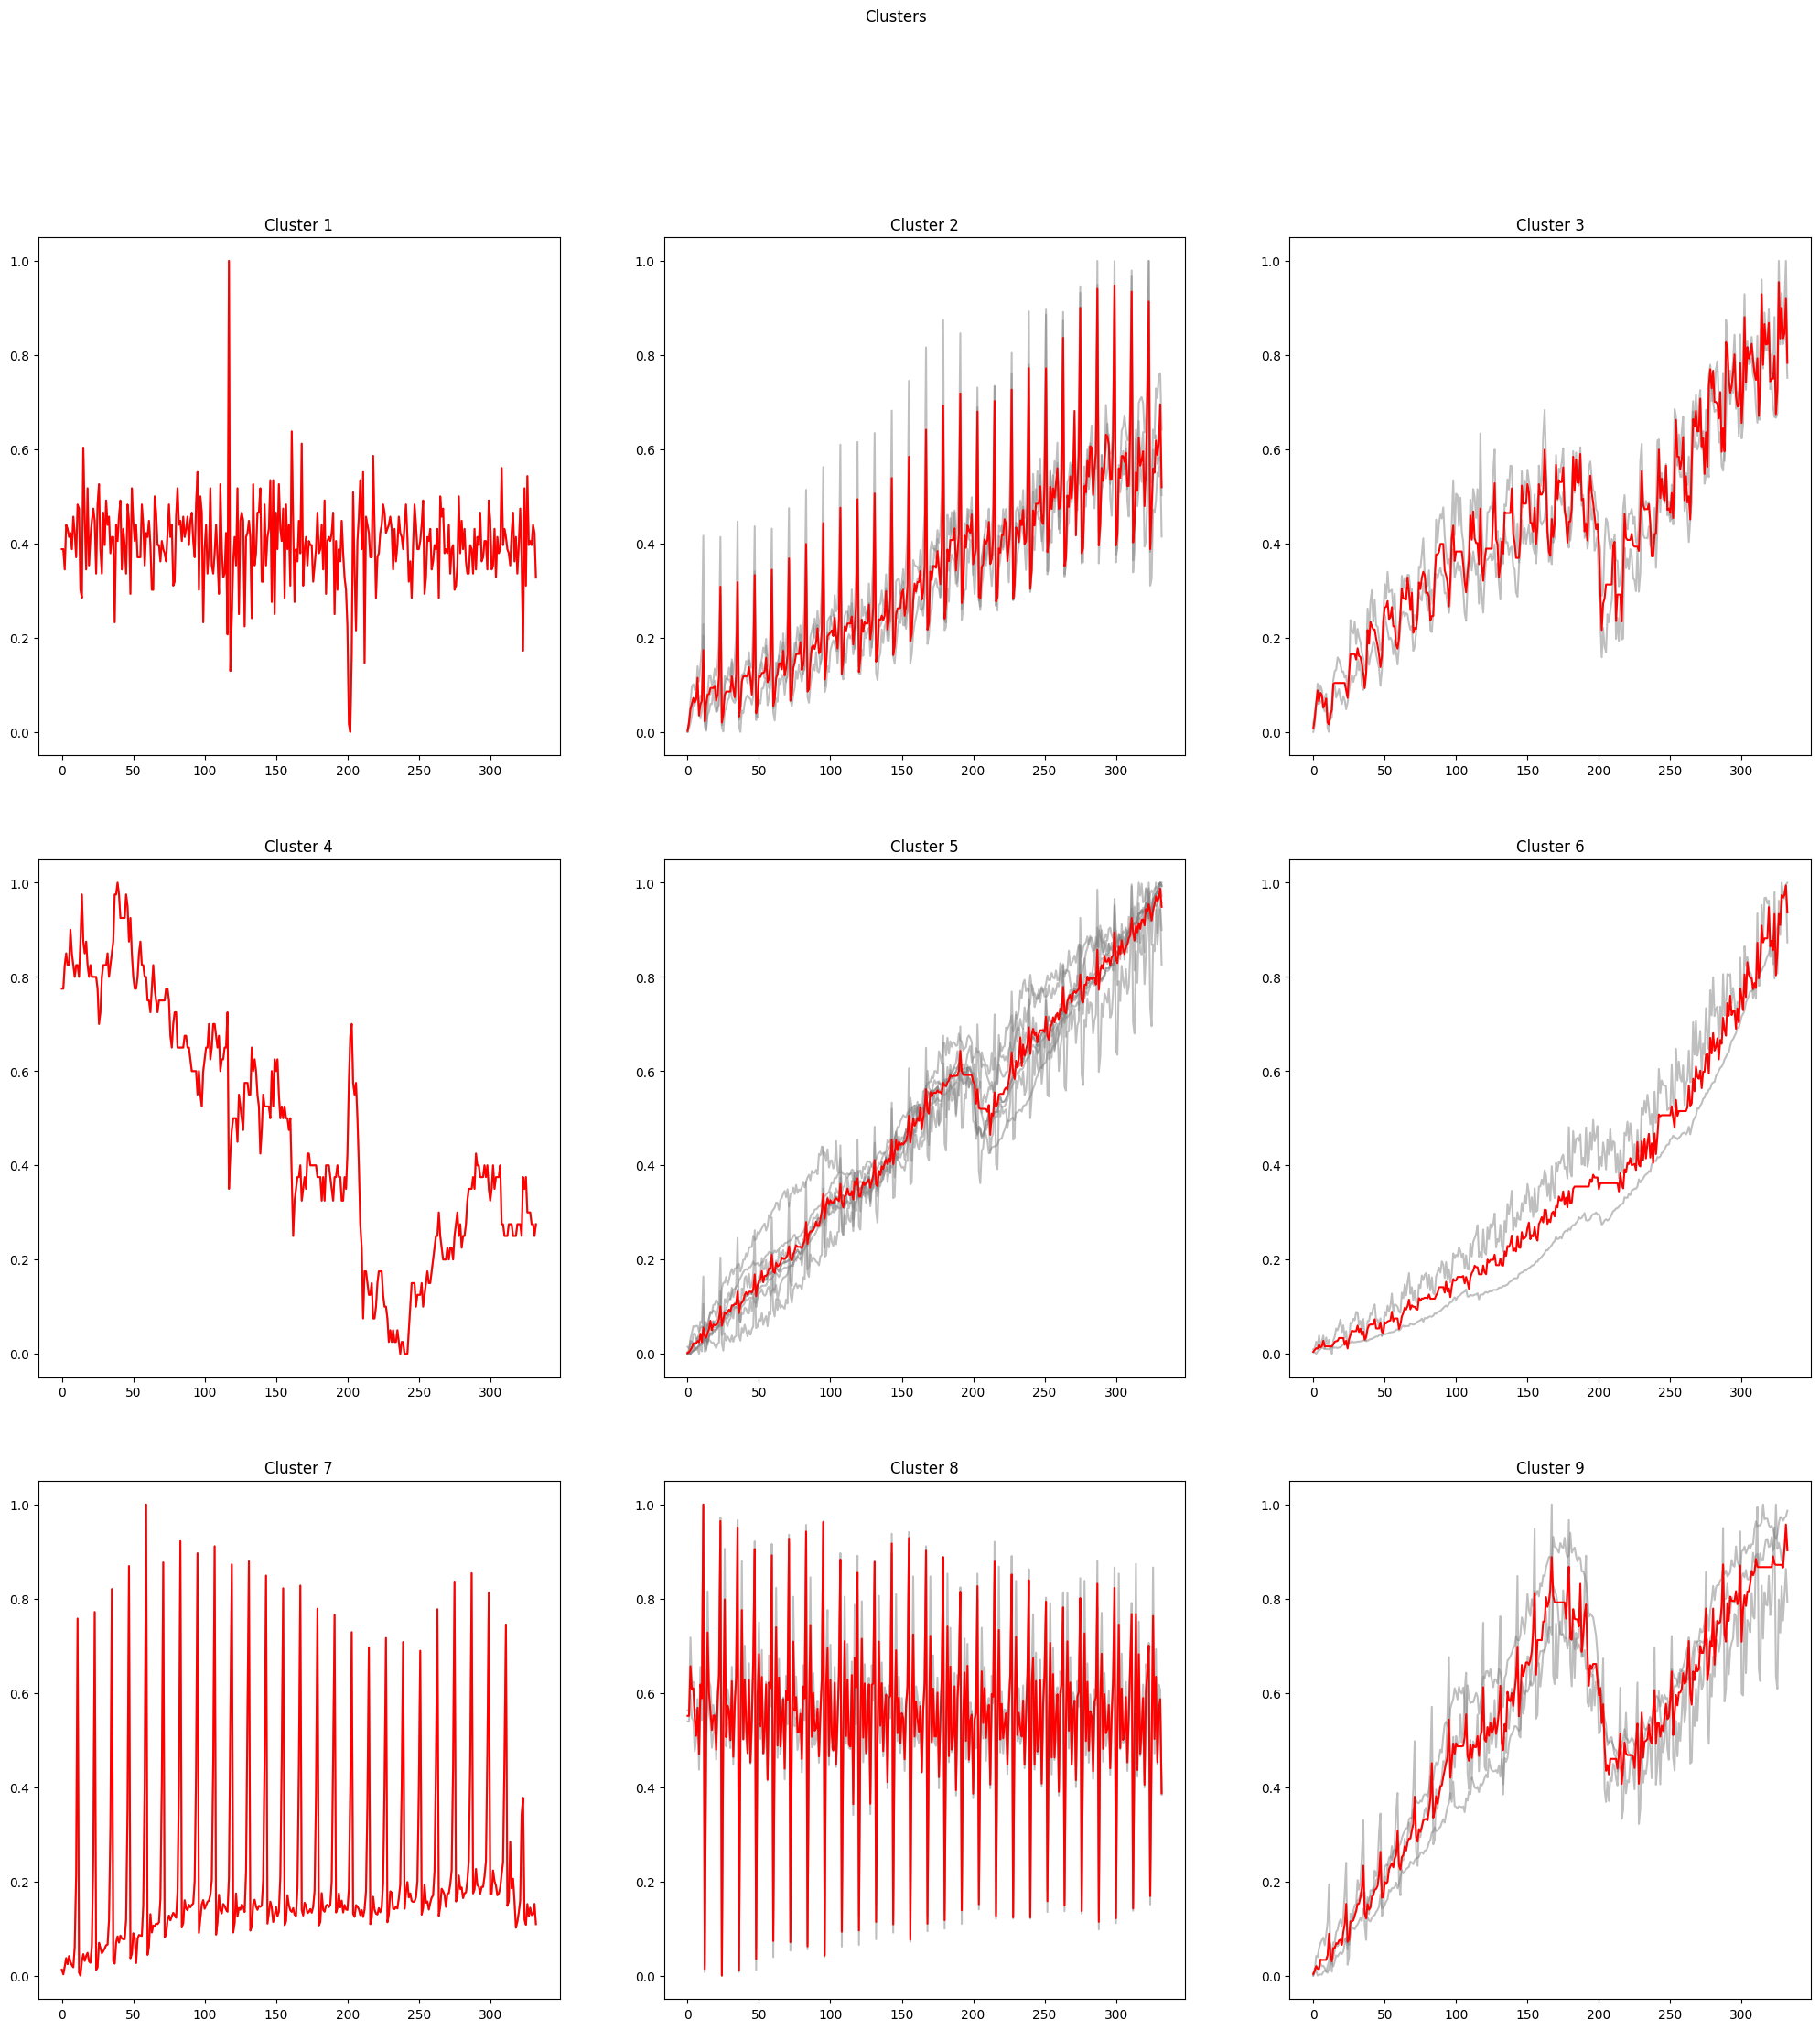

In [56]:
win_map = som.win_map(mySeries)

plot_som_series_dba_center(som_x, som_y, win_map)

Cluster Distribution:
- We can see the distribution of the time series in the clusters in the following chart

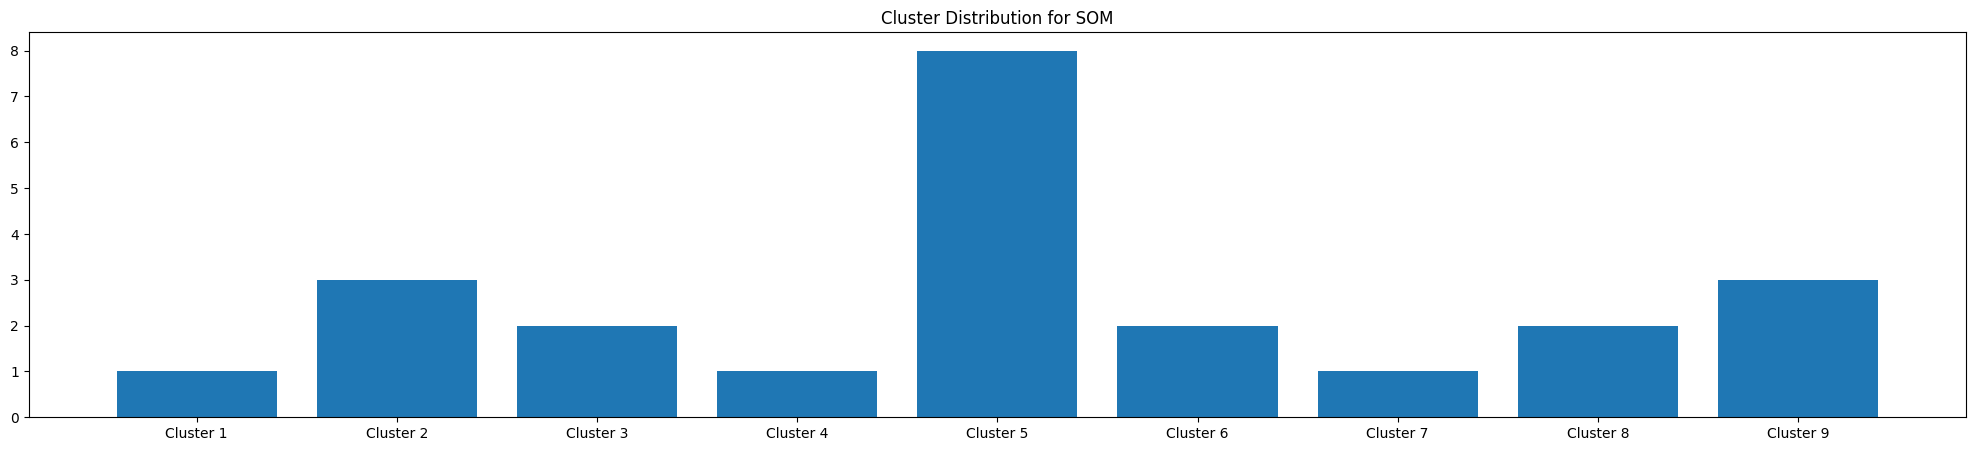

In [57]:
cluster_c = []
cluster_n = []

for x in range(som_x):
    for y in range(som_y):
        cluster = (x,y)
        if cluster in win_map.keys():
            cluster_c.append(len(win_map[cluster]))
        else:
            cluster_c.append(0)
        cluster_number = x*som_y+y+1
        cluster_n.append(f"Cluster {cluster_number}")
plt.figure(figsize=(25,5))
plt.title("Cluster Distribution for SOM")
plt.bar(cluster_n,cluster_c)
plt.show()

In [58]:
len(win_map.keys())

9

We did clustering for our series - but how do we know which series belongs to which cluster.

In [59]:
for series in mySeries[:5]:
    print(som.winner(series))

(2, 1)
(1, 1)
(0, 2)
(0, 2)
(1, 1)


In [61]:
win_map.keys()

dict_keys([(2, 1), (1, 1), (0, 2), (2, 2), (0, 1), (2, 0), (1, 2), (1, 0), (0, 0)])

We can also decide to map each node to a number:

In [62]:
cluster_map = []

for idx in range(len(mySeries)):
    winner_node = som.winner(mySeries[idx])
    cluster_map.append((namesofMySeries[idx],f"Cluster {winner_node[0]*som_y+winner_node[1]+1}"))
pd.DataFrame(cluster_map,columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

,Cluster
Series,
RETAILMPCSMSA,Cluster 1
MRTSSM45111USN,Cluster 2
MRTSSM4453USN,Cluster 2
MRTSSM4481USN,Cluster 2
MRTSSM44111USN,Cluster 3
MRTSSM44112USN,Cluster 3
RETAILIRSA,Cluster 4
MRTSSM448USS,Cluster 5
RETAILIMSA,Cluster 5


K-Means:
- K-Means clustering is a method that aims to cluster n_input to k clusters in which each data point belongs to a cluster with the nearest mean (cluster centroid). 
- In order to cluster our series with k-means, the essential thing to do is, as we do with som, removing our time indices from our time series, and instead of measured values of each date, we should accept them as different features and dimensions of a single data point. Another important thing to do is, selecting the distance metric - we'll be using Dynamic Time Warping in this case.

In [63]:
cluster_count = math.ceil(math.sqrt(len(mySeries)))
# good rule of thumb - choosing k as the sqrt of number of points in the dataset

km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")

labels = km.fit_predict(mySeries)

Results:

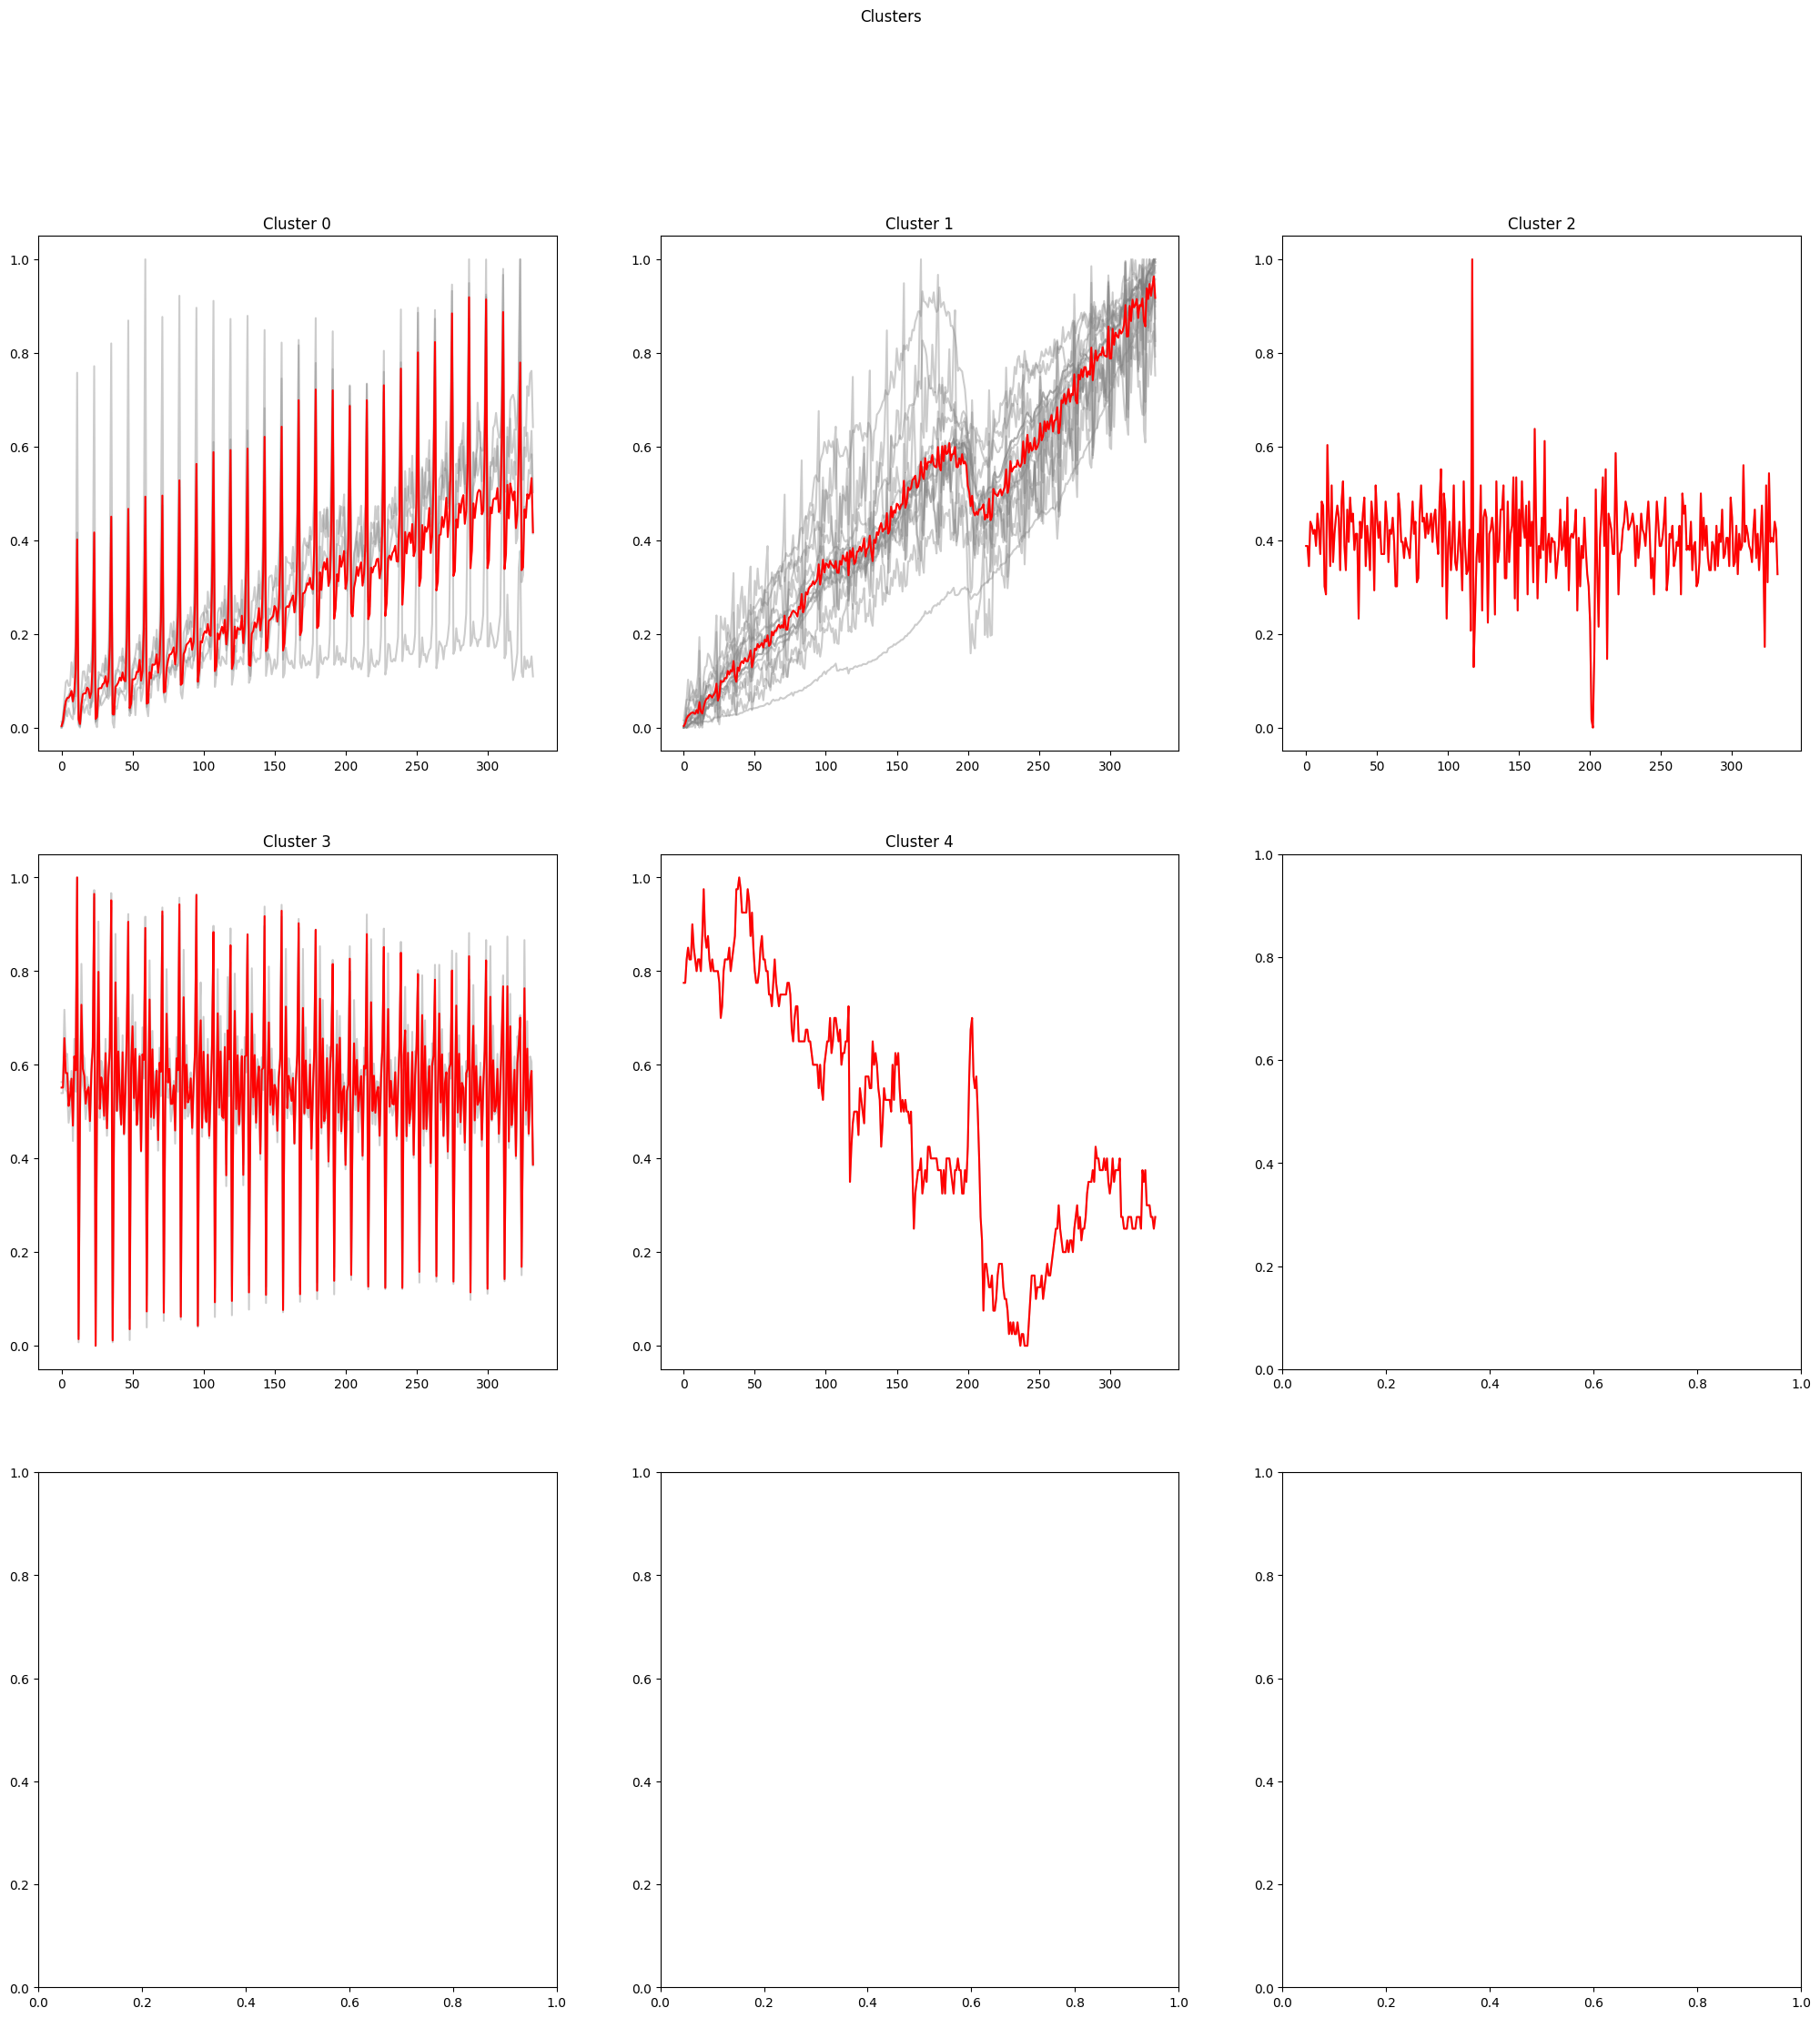

In [64]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

Credit: https://www.kaggle.com/code/izzettunc/introduction-to-time-series-clustering

In [70]:
for i,j in win_map.items():
    print(i,len(j))

(2, 1) 2
(1, 1) 8
(0, 2) 2
(2, 2) 3
(0, 1) 3
(2, 0) 1
(1, 2) 2
(1, 0) 1
(0, 0) 1
